In [1]:
import sys
#sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks') #cambiar ruta segun donde este el archivo 'cuentitas.py' - es probable que deba dar permiso a drive desde el panel izquierdo
import cuentitas
from entornomaximo import entornoMaximo as em
from integracion import integracionGauss as ig
 
from numpy import pi, sqrt, sin, cos, exp, log10, array, real, conj
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy import interpolate
import seaborn as sns
import pandas as pd
import glob
import theano.tensor as TT
 
import pymc3 as pm
#from google.colab import files
sns.set() #seaborn como default

In [2]:
def S0VV_Fran_completo(k0,thi,phi,th,phs,ep1,ep2,d,s1,l1,s2,l2):
    
    k1 = k0*(sin(th)*cos(phs)-sin(thi)*cos(phi))
    k2 = k0*(sin(th)*sin(phs)-sin(thi)*sin(phi))
    
    return 4*np.pi*k0**2*cos(th)**2*(abs(cuentitas.a1VVF1(k0,thi,phi,th,phs,ep1,ep2,d))**2*cuentitas.w(s1,l1,k1,k2)+\
            abs(cuentitas.a1VVF2(k0,thi,phi,th,phs,ep1,ep2,d))**2*cuentitas.w(s2,l2,k1,k2)+\
            2*real(cuentitas.a1VVF1(k0,thi,phi,th,phs,ep1,ep2,d)*conj(cuentitas.a1VVF2(k0,thi,phi,th,phs,ep1,ep2,d)))*cuentitas.w_f1f2(s1,l1,s2,l2,k1,k2))

In [5]:
def toFit(ep1,ep2,d,s1,l1,s2,l2,angulo):
    landa = 0.025
    k0 = 2*np.pi/landa
    phi = np.pi
    
    ### s0
    phs = phi + np.pi
    thi = angulo  #cambiar segun la zona
    thi = thi*np.pi/180 #DU2 T008, T061, T021
    ths = thi
    k1 = k0*(sin(ths)*cos(phs)-sin(thi)*cos(phi))
    k2 = k0*(sin(ths)*sin(phs)-sin(thi)*sin(phi))
 
    aux = 4*np.pi*k0**2*cos(ths)**2*(abs(cuentitas.a1VVF1(k0,thi,phi,ths,phs,ep1,ep2,d))**2*cuentitas.w(s1,l1,k1,k2)+\
            abs(cuentitas.a1VVF2(k0,thi,phi,ths,phs,ep1,ep2,d))**2*cuentitas.w(s2,l2,k1,k2)+\
            2*real(cuentitas.a1VVF1(k0,thi,phi,ths,phs,ep1,ep2,d)*conj(cuentitas.a1VVF2(k0,thi,phi,ths,phs,ep1,ep2,d)))*cuentitas.w_f1f2(s1,l1,s2,l2,k1,k2))
    s0s = 10*np.log10(aux)
    
    ### emi
    thi = 0.0001*np.pi/180
    
    ths_ = (X+1)*np.pi/4
    phs_ = (Y+1)*np.pi
    
    ths_1 = np.reshape(ths_, (1,m**2))
    phs_1 = np.reshape(phs_, (1,m**2))
    
    q = (np.sin(ths_1)*S0VV_Fran_completo(k0,thi,phi,ths_1,phs_1,ep1,ep2,d,s1,l1,s2,l2))
    aux = Wt*q
    I_gauss = (np.pi**2/4)*aux.sum()
 
    emi = 1 - (I_gauss/(4*np.pi))
 
    a = TT.zeros(4)
    aa = TT.set_subtensor(a[0], s0s[0])
    aaa = TT.set_subtensor(aa[1], s0s[1])
    aaaa = TT.set_subtensor(aaa[2], s0s[2])
    aaaaa = TT.set_subtensor(aaaa[3], emi)
 
    return aaaaa

In [3]:
def medicion(zona):     #angulo - observacion - nombre
    if zona == 'VP1':
        out = [np.asarray([20.44, 18.79, 17.36]),np.asarray([-6.13, -5.71, -5.66, 0.927]),'VP1']
    elif zona == 'VP2':
        out = [np.asarray([18.63, 17.19, 11.25]),np.asarray([-6.65, -6.17, -5.93, 0.937]),'VP2']
    elif zona == 'HU0':
        out = [np.asarray([24.59, 15.76, 20.69]),np.asarray([-4.07, -3.27, -3.59, 0.917]),'HU0']
    elif zona == 'HU1':
        out = [np.asarray([22.46, 15.33, 15.57]),np.asarray([-3.64, -3.12, -2.90, 0.921]),'HU1']
    elif zona == 'HU2':
        out = [np.asarray([18.86, 21.10, 12.98]),np.asarray([-4.08, -9.34, -3.55, 0.914]),'HU2']
    elif zona == 'DU1':
        out = [np.asarray([17.20, 20.10, 12.98]),np.asarray([-9.02, -9.55, -8.09, 0.943]),'DU1']
    elif zona == 'DU2':
        out = [np.asarray([23.84, 11.21, 12.64]),np.asarray([-11.96, -6.82, -7.99, 0.954]),'DU2']
    elif zona == 'DP1':
        out = [np.asarray([19.64, 17.76, 14.06]),np.asarray([-7.79, -8.34, -7.44, 0.947]),'DP1']
    elif zona == 'DP2':
        out = [np.asarray([24.21, 13.78, 16.76]),np.asarray([-11.25, -8.29, -8.62, 0.937]),'DP2']
    else:
      print('\n Inputs: VP1, VP2, HU0, HU1, HU2, DU1, DU2, DP1, DP2 \n')
    
    return out

In [7]:
def modelo(sector, samples, sigmas):
 
    landa = 0.025
    k0 = 2*np.pi/landa
    phi = np.pi
 
    ranges = {}
    ranges['ep1'] = 1.4, 8
#    ranges['ep2'] = 1.4, 8
#    ranges['d'] = 0.001, 0.1
    ranges['s1'] = 0.0004, 0.004
#    ranges['l1'] = 0.005, 0.03
#    ranges['s2'] = 0.0004, 0.004
#    ranges['l2'] = 0.005, 0.03
 
    with pm.Model() as model:
        ep1 = pm.Uniform('ep1', ranges['ep1'][0], ranges['ep1'][1])
 #       ep2 = pm.Uniform('ep2', ranges['ep2'][0], ranges['ep2'][1])
 #       d = pm.Uniform('d', ranges['d'][0], ranges['d'][1])
        s1 = pm.Uniform('s1', ranges['s1'][0], ranges['s1'][1])
 #       l1 = pm.Uniform('l1', ranges['l1'][0], ranges['l1'][1])
#        s2 = pm.Uniform('s2', ranges['s2'][0], ranges['s2'][1])
 #       l2 = pm.Uniform('l2', ranges['l2'][0], ranges['l2'][1])
 
    def f(ep1 = ep1, 
     #          ep2 = ep2, 
     #          d = d, 
               s1 = s1, 
     #          l1 = l1,
     #          s2 = s2, 
     #          l2 = l2
         ):
        return toFit(ep1,3,0.05,s1,0.015,0.001,0.015,sector[0])
 
    with model:
        function_pm = pm.Deterministic('s0f', f())
        observations = pm.Normal( "obs",  mu=real(function_pm), sigma=sigmas, observed=sector[1])
        trace = pm.sample_smc(samples)  #porque no corre las cadenas en parelelo? Es mas rapido False
        #trace = pm.sample_smc(samples, cores=2, parallel=False) #probar con 4 
    
    return trace

In [12]:
m = 51
X,Y,Wt = ig(m-1)

zonaMed = 'HU2'
muestras = 50000
sigmas = np.asarray([0.1, 0.1, 0.1, 0.01])

#traza = modelo(medicion(zonaMed),muestras,sigmas)
traza = modelo([np.asarray([10,15,20]),np.asarray([-4.639,-7.020,-10.492,0.985]),'HU2'],muestras,sigmas)


In [8]:
e1 = traza['ep1']
#e2 = traza['ep2']
#d = traza['d']
s1 = traza['s1']
#l1 = traza['l1']
#s2 = traza['s2']
#l2 = traza['l2']

guardar = [e1,s1]#,e2,d,s1,l1,s2,l2]
#ruta = '/content/drive/MyDrive/Tesis de Javi/DatosSimu/'+zonaMed+'-s1l1-s=50k.txt'
#ruta = '/content/drive/MyDrive/Tesis de Javi/DatosSimu/Nuevos/'+zonaMed+'-N='+str(n)+'-S='+str(muestras)+'.txt'
#f = np.savetxt(zonaMed+'-N='+str(n)+'-S='+str(muestras)+'SSA.txt', guardar, delimiter=';')
#f = np.savetxt('prueba-e1s1.txt', guardar, delimiter=';')
print('Archivo guardado')


NameError: name 'traza' is not defined

Ploteando...


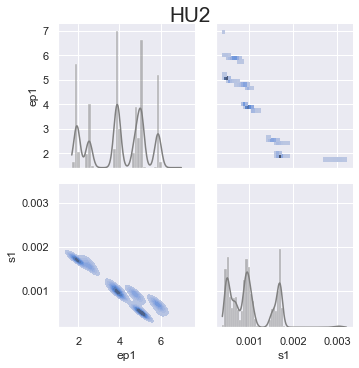

In [110]:
#Ploteo
print('Ploteando...')

plotear = np.stack((traza['ep1'], traza['s1'])).T#, traza['d'], traza['s1'], traza['l1'], traza['s2'], traza['l2'])).T 
dfplotear = pd.DataFrame(plotear, columns = ['ep1','s1'])#,'d','s1','l1','s2','l2'])

g = sns.PairGrid(dfplotear)
g.fig.suptitle(zonaMed, y=1.01, fontsize = 'xx-large')
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True, color='.5')
#g.savefig('prueba.png')
#files.download('prueba.png') #descarga la imagen

---------
Prueba sobre cada maximo

In [13]:
def prueba(ep1,ep2,d,s1,l1,s2,l2,angulo): #funcion de antes pero sin la parte tensorial
    landa = 0.025
    k0 = 2*np.pi/landa
    phi = np.pi
    ### s0
    phs = phi + np.pi
    thi = angulo  #cambiar segun la zona
    thi = thi*np.pi/180 #DU2 T008, T061, T021
    ths = thi
    k1 = k0*(sin(ths)*cos(phs)-sin(thi)*cos(phi))
    k2 = k0*(sin(ths)*sin(phs)-sin(thi)*sin(phi))
 
    aux = 4*np.pi*k0**2*cos(ths)**2*(abs(cuentitas.a1VVF1(k0,thi,phi,ths,phs,ep1,ep2,d))**2*cuentitas.w(s1,l1,k1,k2)+\
            abs(cuentitas.a1VVF2(k0,thi,phi,ths,phs,ep1,ep2,d))**2*cuentitas.w(s2,l2,k1,k2)+\
            2*real(cuentitas.a1VVF1(k0,thi,phi,ths,phs,ep1,ep2,d)*conj(cuentitas.a1VVF2(k0,thi,phi,ths,phs,ep1,ep2,d)))*cuentitas.w_f1f2(s1,l1,s2,l2,k1,k2))
    s0s = 10*np.log10(aux)
    
    ### emi
    X,Y,Wt = ig(50)
    
    thi = 0.0001*np.pi/180
    
    ths_ = (X+1)*np.pi/4
    phs_ = (Y+1)*np.pi
    
    ths_1 = np.reshape(ths_, (1,m**2))
    phs_1 = np.reshape(phs_, (1,m**2))
    
    q = (np.sin(ths_1)*S0VV_Fran_completo(k0,thi,phi,ths_1,phs_1,ep1,ep2,d,s1,l1,s2,l2))
    aux = Wt*q
    I_gauss = (np.pi**2/4)*aux.sum()
 
    emi = 1 - (I_gauss/(4*np.pi))

    return s0s, emi

In [38]:
#Genero los valores del modelo para estos angulos incidentes
angPrueba = [10,15,20]

for i in angPrueba:
    print('thi = ',i,': ',prueba(1.93,3,0.05,0.0017,0.015,0.001,0.015,i))

#esto es lo que devuelve
back = [-4.639,-7.020,-10.492]

thi =  10 :  (-4.639658114654706, 0.9854867397806576)
thi =  15 :  (-7.020294116808399, 0.9854867397806576)
thi =  20 :  (-10.492452448846416, 0.9854867397806576)


In [7]:
pru = np.loadtxt('prueba-e1s1.txt', delimiter=';') #output del sampler

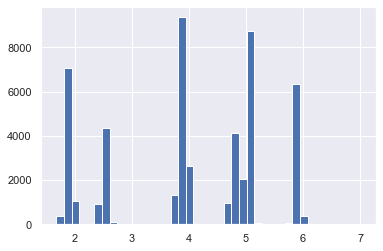

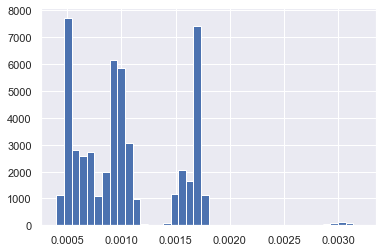

In [8]:
y, x, _ = plt.hist(pru[0],bins=40)
plt.figure()
y2, x2, _2 = plt.hist(pru[1],bins=40)
y2 = np.asarray(y2)
x2 = np.asarray(x2)

In [36]:
ee = [x[16],x[25],x[1],x[31],x[6],x[23]]
ss = [x2[0],x2[17],x2[6],x2[7]] #Anote cuales son los indices en mi libretita
print(ss)
print(ee)
auxx1 = []
auxx2 = []
auxx3 = []
for e in range(len(ee)):
    for s in range(len(ss)):
        print('\n eps1 = ', ee[e],' - s1 = ',ss[s])
        print(prueba(ee[e],3,0.05,ss[s],0.015,0.001,0.015,10))
        print(prueba(ee[e],3,0.05,ss[s],0.015,0.001,0.015,15))
        print(prueba(ee[e],3,0.05,ss[s],0.015,0.001,0.015,20))
        auxx1.append(prueba(ee[e],3,0.05,ss[s],0.015,0.001,0.015,10))
        auxx2.append(prueba(ee[e],3,0.05,ss[s],0.015,0.001,0.015,15))
        auxx3.append(prueba(ee[e],3,0.05,ss[s],0.015,0.001,0.015,20))

[0.0004003661684850914, 0.0015933870327917662, 0.0008214323558874472, 0.0008916100537878398]
[3.8103828506473536, 5.010116979069004, 1.8108259699446037, 5.809939731350104, 2.4773449301788535, 4.7435093949753036]

 eps1 =  3.8103828506473536  - s1 =  0.0004003661684850914
(-11.68975125587416, 0.996605331381465)
(-14.131996961065491, 0.996605331381465)
(-17.41114349391433, 0.996605331381465)

 eps1 =  3.8103828506473536  - s1 =  0.0015933870327917662
(-1.568720644678945, 0.9658951697526235)
(-4.008483984991635, 0.9658951697526235)
(-7.266854220634632, 0.9658951697526235)

 eps1 =  3.8103828506473536  - s1 =  0.0008214323558874472
(-6.907396236715274, 0.9899631209595513)
(-9.347806265855676, 0.9899631209595513)
(-12.611578292297608, 0.9899631209595513)

 eps1 =  3.8103828506473536  - s1 =  0.0008916100537878398
(-6.277875294667168, 0.9884109845093717)
(-8.718161977041898, 0.9884109845093717)
(-11.9809031073586, 0.9884109845093717)

 eps1 =  5.010116979069004  - s1 =  0.0004003661684850914

In [34]:
auxx1 = np.asarray(auxx1)
auxx2 = np.asarray(auxx2)
auxx3 = np.asarray(auxx3)


Text(0, 0.5, 'emisividad')

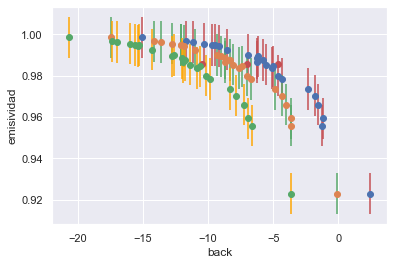

In [35]:
plt.errorbar(auxx1[:,0],auxx1[:,1],yerr=0.01,xerr=0.1,ecolor='r',fmt='o')
plt.errorbar(auxx2[:,0],auxx2[:,1],yerr=0.01,xerr=0.1,ecolor='g',fmt='o')
plt.errorbar(auxx3[:,0],auxx3[:,1],yerr=0.01,xerr=0.1,ecolor='orange',fmt='o')

plt.plot([-4.639658114654706,-7.020294116808399,-10.492452448846416],[0.9854867397806576,0.9854867397806576,0.9854867397806576],'or')
plt.xlabel('back')
plt.ylabel('emisividad')


----------